# Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

import plotly as px
import plotly.graph_objects as go

# Read file and display table information

In [2]:
# Set the directory you want to start from
data_dir = '/kaggle/input/trip-data/Dataset_12m'

In [3]:
dataframes = []  # List to store all dataframes

# Retrieve and sort all subdirectories in descending order
all_dirs = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))], reverse=True)

# Process only the latest 12 directories
for dirName in all_dirs[:12]:
    dir_path = os.path.join(data_dir, dirName)
    for fname in os.listdir(dir_path):
        if fname.endswith('.csv'):  # Ensure the file is a CSV
            filepath = os.path.join(dir_path, fname)
            df = pd.read_csv(filepath)
            dataframes.append(df)

# Now that we have all dataframes in a list, we can concatenate them.
data_df = pd.concat(dataframes, ignore_index=True)

# To check the combined data
data_df.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,31D38723D5A8665A,electric_bike,2024-09-26 15:30:58.150,2024-09-26 15:30:59.437,NaN,NaN,NaN,NaN,41.91,-87.63,41.91,-87.63,member
1,67CB39987F4E895B,electric_bike,2024-09-26 15:31:32.529,2024-09-26 15:53:13.501,NaN,NaN,NaN,NaN,41.91,-87.63,41.91,-87.63,member
2,DA61204FD26EC681,electric_bike,2024-09-26 15:00:33.012,2024-09-26 15:02:25.406,NaN,NaN,NaN,NaN,41.90,-87.62,41.90,-87.63,member
3,06F160D46AF235DD,electric_bike,2024-09-26 18:19:06.491,2024-09-26 18:38:53.515,NaN,NaN,NaN,NaN,41.91,-87.63,41.90,-87.62,member
4,6FCA41D4317601EB,electric_bike,2024-09-03 19:49:57.054,2024-09-03 20:07:08.464,NaN,NaN,NaN,NaN,41.90,-87.69,41.90,-87.63,member


In [4]:
data_df.shape

(5854544, 13)

In [5]:
# Non-null values 
non_null_values = data_df.notnull().sum()

# Missing values
missing_values = data_df.isnull().sum()

<Figure size 2000x1500 with 0 Axes>

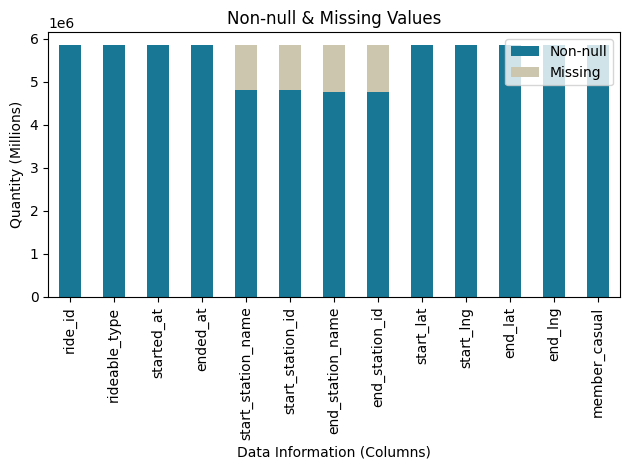

In [6]:
# Create DataFrame for chart
combined_data = pd.DataFrame({
    'Non-null': non_null_values,
    'Missing': missing_values
})

plt.figure(figsize=(20, 15))
combined_data.plot(kind='bar', stacked=True, color=['#187795', '#CDC6AE'])
plt.title('Non-null & Missing Values')
plt.xlabel('Data Information (Columns)')
plt.ylabel('Quantity (Millions)')
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [7]:
data_df.describe()

,start_lat,start_lng,end_lat,end_lng
count,5.854544e+06,5.854544e+06,5.847103e+06,5.847103e+06
mean,4.190222e+01,-8.764635e+01,4.190261e+01,-8.764659e+01
std,4.476293e-02,2.741176e-02,5.326143e-02,5.528944e-02
min,4.164000e+01,-8.794000e+01,1.606000e+01,-1.440500e+02
25%,4.188096e+01,-8.766000e+01,4.188096e+01,-8.766000e+01
50%,4.189749e+01,-8.764288e+01,4.189820e+01,-8.764299e+01
75%,4.193000e+01,-8.762952e+01,4.193000e+01,-8.762954e+01
max,4.207000e+01,-8.752000e+01,8.796000e+01,1.720000e+00


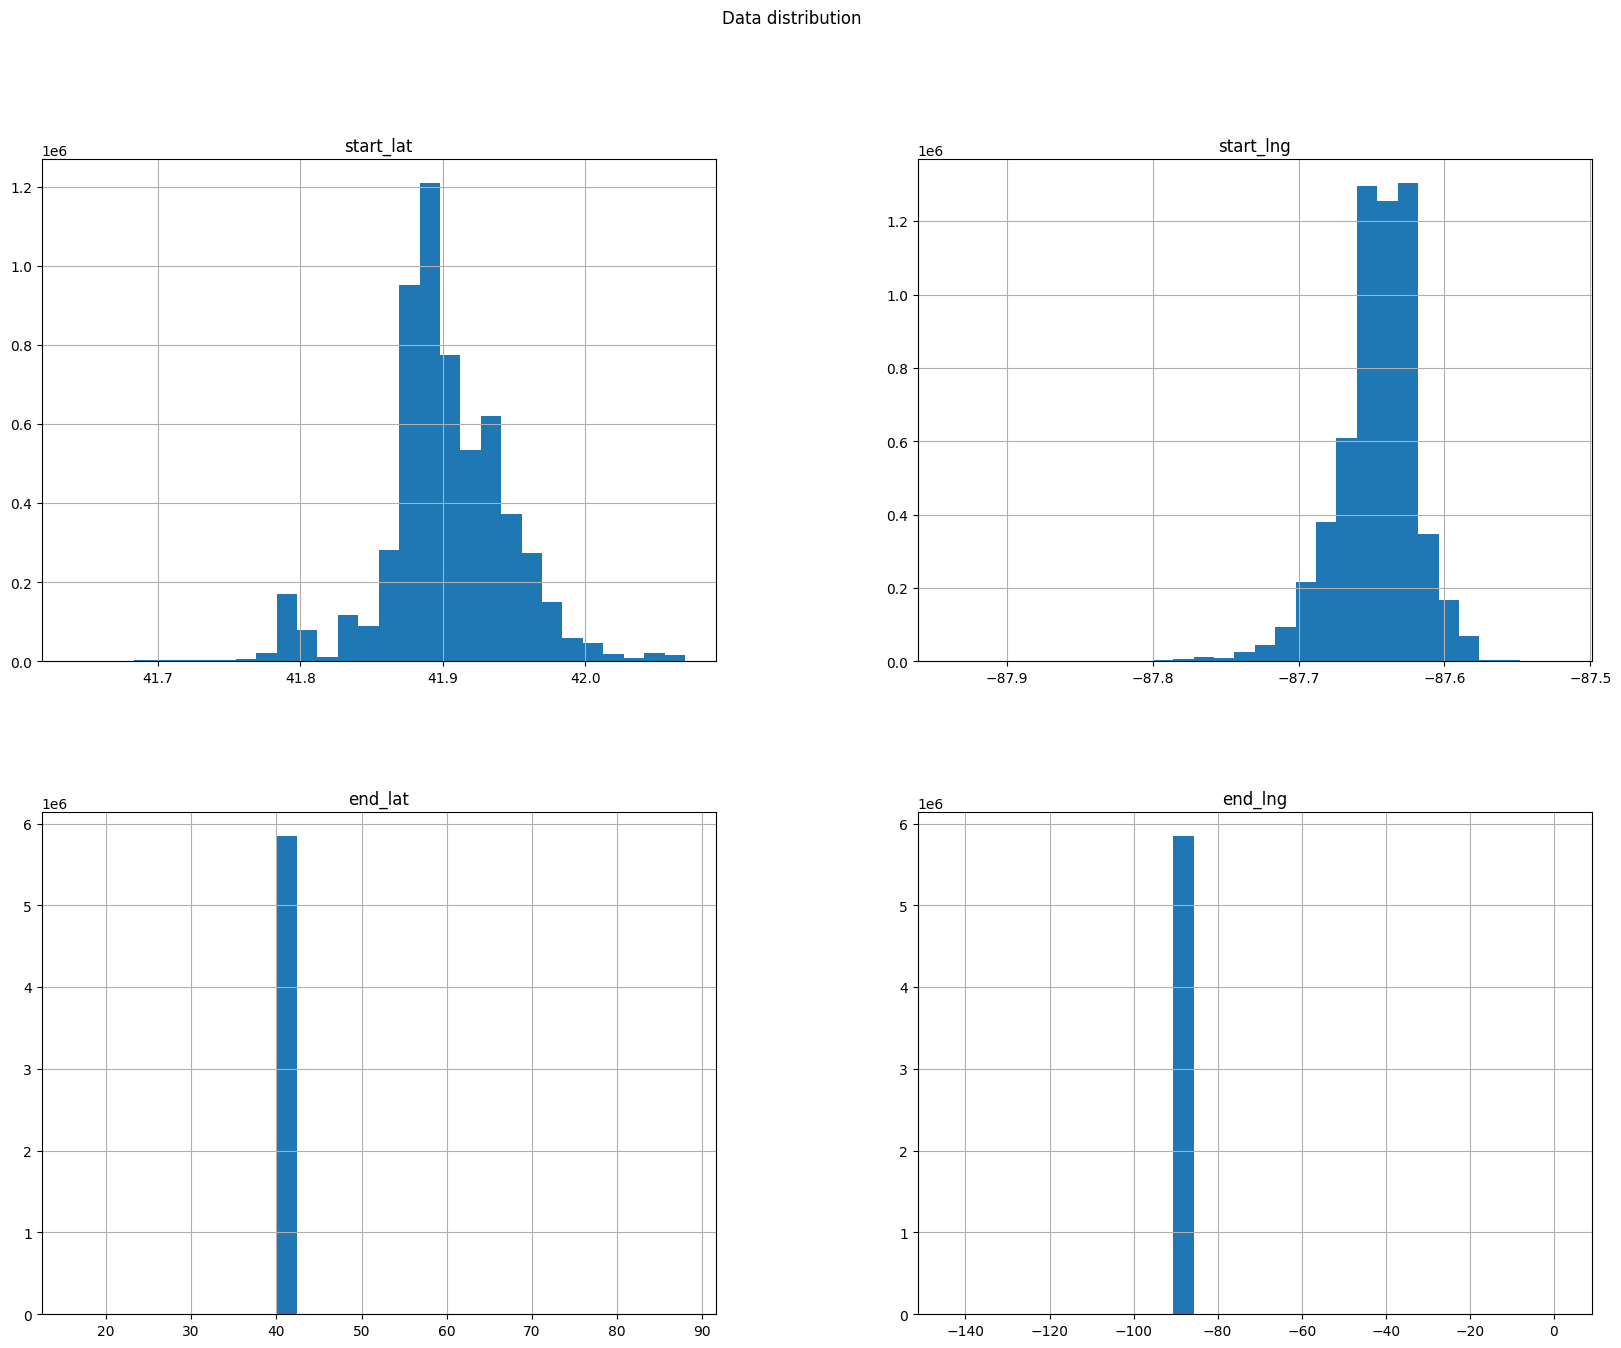

In [8]:
# Histogram for Number Columns
data_df.hist(figsize=(20, 15), bins=30)
plt.suptitle('Data distribution')
plt.show()

In [9]:
# Unique values for each colums
unique_counts = data_df.nunique()
print(unique_counts)

ride_id               5854333
rideable_type               3
started_at            5505329
ended_at              5510373
start_station_name       1737
start_station_id         1700
end_station_name         1749
end_station_id           1710
start_lat              661743
start_lng              635435
end_lat                  2722
end_lng                  2739
member_casual               2
dtype: int64


# Dropping Irrelevant Columns: 'start_station_id' + 'end_station_id'

In [10]:
def drop_columns(df, cols_list):
    df = df.drop(cols_list, axis=1)
    return df

# Drop 'start_station_id' and 'end_station_id'
cols_list = ['start_station_id', 'end_station_id']
data_df = drop_columns(data_df, cols_list)

# Fixing Data Types and Removing Duplicates

In [11]:
def remove_dup(df):

    # Remove duplicates
    data_df.drop_duplicates(inplace=True)

    # Return the processed dataframe
    return data_df

# Use the function on your data
data_df = remove_dup(data_df)

# Handling Missing Data

In [12]:
def handle_missing_values(data_df, threshold=20000):
    # Handle number columns
    for col in data_df.select_dtypes(include=['float64', 'int64']).columns:
        data_df[col].fillna(data_df[col].mean(), inplace=True)
        
    # Handle columns start_station_name & end_station_name
    for column in ['start_station_name', 'end_station_name']:
        # Get the frequency of each label
        freq = data_df[column].value_counts()
        # Find labels with frequency below threshold
        rare_labels = freq[freq < threshold].index
        # Replace rare labels with 'Other'
        data_df[column] = data_df[column].apply(lambda x: 'Other' if x in rare_labels else x)
    
    # Fill in 'Unknown' for missing values
    data_df['start_station_name'].fillna('Unknown', inplace=True)
    data_df['end_station_name'].fillna('Unknown', inplace=True)
    
    # Handling string columns
    for col in data_df.select_dtypes(include=['object']).columns:
        data_df[col].fillna(data_df[col].mode()[0], inplace=True)
    
    return data_df

# Use functions to handle missing values
data_df = handle_missing_values(data_df)

In [13]:
data_df.head(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual
0,31D38723D5A8665A,electric_bike,2024-09-26 15:30:58.150,2024-09-26 15:30:59.437,Unknown,Unknown,41.91,-87.63,41.91,-87.63,member
1,67CB39987F4E895B,electric_bike,2024-09-26 15:31:32.529,2024-09-26 15:53:13.501,Unknown,Unknown,41.91,-87.63,41.91,-87.63,member
2,DA61204FD26EC681,electric_bike,2024-09-26 15:00:33.012,2024-09-26 15:02:25.406,Unknown,Unknown,41.90,-87.62,41.90,-87.63,member
3,06F160D46AF235DD,electric_bike,2024-09-26 18:19:06.491,2024-09-26 18:38:53.515,Unknown,Unknown,41.91,-87.63,41.90,-87.62,member
4,6FCA41D4317601EB,electric_bike,2024-09-03 19:49:57.054,2024-09-03 20:07:08.464,Unknown,Unknown,41.90,-87.69,41.90,-87.63,member
5,9F291E82895C45E5,electric_bike,2024-09-04 01:45:18.863,2024-09-04 02:01:38.209,Unknown,Unknown,41.90,-87.63,41.90,-87.69,member
6,625D2EA831E1F8AC,electric_bike,2024-09-04 16:22:16.399,2024-09-04 16:26:20.740,Unknown,Unknown,41.89,-87.63,41.89,-87.63,member
7,A21DCB6834BCAD0D,electric_bike,2024-09-04 16:31:58.949,2024-09-04 16:38:52.990,Unknown,Unknown,41.89,-87.63,41.89,-87.63,member
8,0EEB8A4CF63DA7AE,electric_bike,2024-09-28 20:30:28.855,2024-09-28 20:33:20.734,Unknown,Unknown,41.90,-87.64,41.90,-87.63,member
9,6CE10020F5D0D7B8,electric_bike,2024-09-28 20:10:48.319,2024-09-28 20:24:32.730,Unknown,Unknown,41.92,-87.68,41.90,-87.64,member


In [14]:
print(data_df.dtypes)

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
end_station_name       object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object


In [15]:
from math import radians, cos, sin, sqrt, atan2

def calculate_distance(row):
    # Radius of the earth in km
    R = 6371.0

    lat1 = radians(row['start_lat'])
    lon1 = radians(row['start_lng'])
    lat2 = radians(row['end_lat'])
    lon2 = radians(row['end_lng'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Convert to kilometers
    distance = R * c

    return distance

def create_features(df):
    # Convert columns 'started_at' & 'ended_at' to datetime type
    df['started_at'] = pd.to_datetime(df['started_at'], format='mixed')
    df['ended_at'] = pd.to_datetime(df['ended_at'], format='mixed')

    # Create column 'ride_length' by subtraction 'started_at' from 'ended_at'
    df['ride_length'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

    # Create column 'day_of_week'
    df['day_of_week'] = df['started_at'].dt.dayofweek + 1  # Monday is 0, Sunday is 6 by default
    df['day_of_week'] = df['day_of_week'] % 7 + 1  # Transform Monday to be 7, and then change Sunday to be 1

    # Create column 'hour'
    df['hour'] = df['started_at'].dt.hour

    # Create column 'month'
    df['month'] = df['started_at'].dt.month

    # Create column 'year'
    df['year'] = df['started_at'].dt.year
    
    # Create bins for 'ride_length'
    bins = [0, 10, 20, 30, 40, 50, 60, np.inf]
    names = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+']
    df['ride_length_category'] = pd.cut(df['ride_length'], bins, labels=names)
    
    # Calculate distance (km)
    df['distance_km'] = df.apply(calculate_distance, axis=1)
    

    return df

data_df = create_features(data_df)

In [16]:
data_df.tail(10)

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,hour,month,year,ride_length_category,distance_km
5854534,362C6E0FCE05C262,classic_bike,2023-10-03 07:34:29,2023-10-03 09:32:03,Other,Other,41.864059,-87.623727,41.864059,-87.623727,casual,117.566667,3,7,10,2023,60+,0.000000
5854535,B79614366F0B86C8,electric_bike,2023-10-05 22:36:23,2023-10-05 22:43:05,Other,Other,41.936090,-87.669939,41.946655,-87.683359,casual,6.700000,5,22,10,2023,<10,1.616257
5854536,FDF083F0E92F13E4,classic_bike,2023-10-28 09:27:51,2023-10-28 09:28:55,Other,Other,41.864059,-87.623727,41.864059,-87.623727,casual,1.066667,7,9,10,2023,<10,0.000000
5854537,A934D4AAD867B08D,electric_bike,2023-10-28 10:52:36,2023-10-28 11:00:11,Other,Other,41.891915,-87.620558,41.891847,-87.620580,casual,7.583333,7,10,10,2023,<10,0.007741
5854538,E264BF85F3DCCFDB,electric_bike,2023-10-11 17:10:52,2023-10-11 17:36:33,Clinton St & Washington Blvd,Other,41.883697,-87.641315,41.891847,-87.620580,casual,25.683333,4,17,10,2023,20-30,1.940970
5854539,CB82F1F5D0505469,classic_bike,2023-10-30 07:35:46,2023-10-30 07:49:30,Clinton St & Washington Blvd,Other,41.883380,-87.641170,41.891847,-87.620580,member,13.733333,2,7,10,2023,10-20,1.947182
5854540,E2C362589E4AD3A9,classic_bike,2023-10-10 06:29:55,2023-10-10 06:45:19,Clark St & Lincoln Ave,Other,41.915689,-87.634600,41.891847,-87.620580,member,15.400000,3,6,10,2023,10-20,2.893850
5854541,965D4156EDECF21A,classic_bike,2023-10-26 06:26:23,2023-10-26 06:39:43,Clinton St & Washington Blvd,Other,41.883380,-87.641170,41.891847,-87.620580,member,13.333333,5,6,10,2023,10-20,1.947182
5854542,0919ED32225E4D31,classic_bike,2023-10-09 08:47:29,2023-10-09 08:47:33,Other,Other,41.864059,-87.623727,41.864059,-87.623727,member,0.066667,2,8,10,2023,<10,0.000000
5854543,34C4F779743D5F49,electric_bike,2023-10-13 17:30:30,2023-10-13 17:42:15,Clinton St & Washington Blvd,Other,41.883543,-87.641270,41.870816,-87.631246,member,11.750000,6,17,10,2023,10-20,1.640553


# Export the table to Excel and continue processing

In [17]:
def export_to_excel(df, file_name_prefix):
    # Chia dữ liệu thành các phần dựa trên cột 'month' và 'year'
    for year in [2023, 2024]:
        for month in range(1, 13):
            if year == 2023 and month not in [10, 11, 12]:
                continue
            if year == 2024 and month not in range(1, 10):
                continue
            
            # Lấy dữ liệu của tháng và năm hiện tại
            df_month_year = df[(df['year'] == year) & (df['month'] == month)]
            
            # Tạo tên file cho từng tháng và năm
            chunk_file_name = f"{file_name_prefix}_{year}_{month:02d}.csv"
            
            # Xuất dữ liệu ra file Excel
            df_month_year.to_csv(chunk_file_name, index=False)

# Sử dụng hàm để xuất data_df ra các file Excel theo tháng và năm
export_to_excel(data_df, 'tripdata')
